<a href="https://colab.research.google.com/github/hululuzhu/mario-rl/blob/main/12_2021_RC1_Super_Mario_Stable_Baselines3_PPO_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to try out this Super Mario RL colab
- We used Stable Baselines3 PPO
- We downsampled the images to speed up training
- We choose best-1-of-20-episodes in evaluation (save_gif) to "cheat", a common
practice is to "average" instead of "best", we tried to save time to see effect 
sooner
- If you like to periodically save your model/gif, please mount to your Drive and update the path in "core code" section
- For more info, check out https://github.com/hululuzhu/mario-rl
- Slides: [1.5h 2022 version for students](https://docs.google.com/presentation/d/e/2PACX-1vQi060aTNB7PblBe8lwlrCoonhhhJuVI4uRQLu2CeTthz-WRJ3RkCSmIrTFPPh06SBquDIlgUfqi8h-/pub?start=false&loop=false&delayms=3000) or [1h 2021 version for my colleagues](https://docs.google.com/presentation/d/e/2PACX-1vRH3idUYN3IYpI7LmXL0_Y_VVkAtKUlOE2dUjVWcZokr2h7gKiBnKK1zDdKo5e5SqqBZtB198JW13Dq/pub?start=false&loop=false&delayms=3000)
- todo: the reward function in evaluation seems broken, to be fixed as of 12/2021

In [ ]:
# Check out https://pypi.org/project/gym-super-mario-bros/ for more info
# 8 worlds and 4 stages = 32 levels (I only tried 1-1 so far)
WORLD = 1  # @param {type:"slider", min:1, max:8, step:1}
STAGE = 1  # @param {type:"slider", min:1, max:4, step:1}
LEVEL = f"{WORLD}-{STAGE}"
# 0 high, 1 low, 2 down, 3 lowest
QUALITY = 0 # @param {type:"slider", min:0, max:4, step:1}
DEFAULT_GAME = f"SuperMarioBros-{LEVEL}-v{QUALITY}"
# Simplest list of actions, see full list https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py
MY_ACTIONS = [["right"], ["right", "A"]]


# Important to set the 2 params below to affect time, each 50k steps takes ~11min in Nvidia P100 GPU at Colab
# Literature suggests  batches*each_batch_steps to exceed 10M to get reliably good Mario AI
# change to higher number for real run, 2 for test
batches = 2 # @param {type:"integer"}
# Change to 500k or more to expect see real impact, 50 for test the flow
each_batch_steps = 50 # @param {type:"integer"}

# Imports and support methods

In [ ]:
# @title Install necessary packages, ~3 mins
!pip install -q stable-baselines3[extra] > /dev/null 2>&1
!pip install -q gym-super-mario-bros > /dev/null 2>&1
# Virtual display needed for render function
!pip install -q gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -q -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# To display gif natively
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [ ]:
# @title Creates virtual display
import os
os.system("Xvfb :1 -screen 0 256x140x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
# @title Imports for this colab, if seeing error, restart instance
# ----Display and system needed----
from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display
import base64
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
import numpy as np
import torch

# ----Game Env and Transform needed----
import gym
from gym.spaces import Box
import gym_super_mario_bros
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
from gym.wrappers import FrameStack
from torchvision import transforms

# ----PPO RL Algorithm----
from stable_baselines3 import PPO

# Model

In [ ]:
# @title Support method to create env and downsample
# Reference: https://github.com/pytorch/tutorials/blob/master/intermediate_source/mario_rl_tutorial.py
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        my_transforms = transforms.Compose(
            [transforms.Resize(self.shape), transforms.Normalize(0, 255)]
        )
        observation = my_transforms(observation).squeeze(0)
        return observation


# Apply Wrappers to environment, notice we limit the action spaces to
# MY_ACTIONS which only has 2 actions
def build_env():
  env = gym_super_mario_bros.make(DEFAULT_GAME)
  env = SkipFrame(env, skip=4)
  env = GrayScaleObservation(env)
  env = ResizeObservation(env, shape=84)
  env = FrameStack(env, num_stack=4)
  env = JoypadSpace(env, MY_ACTIONS)
  return env

Human sees


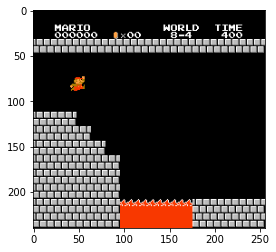

Model sees


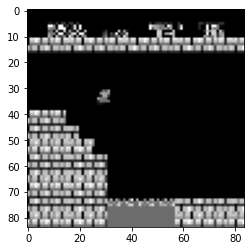

In [ ]:
# @title Output one frame that will feed to model
def see_world(test_env):
  obs = test_env.reset()
  for i in range(10):
      action = test_env.action_space.sample()
      obs, reward, done, info = test_env.step(action)

  from matplotlib import pyplot as plt
  if obs.shape[0] == 4:
    plt.imshow(obs[-1], cmap='gray')
  else:
    plt.imshow(obs)
  plt.show()
  del test_env
print("Human sees")
see_world(gym_super_mario_bros.make(DEFAULT_GAME))
print("Model sees")
see_world(build_env())

In [ ]:
# @title Support method to save GIF to evaluate. Please note we "cheated" by using best-1-of-20, ideally use average
display = Display(visible=0, size=(400, 300))
display.start()


def save_gif(model, image_file, max_steps=2000):
  best_img = []
  all_rewards = []
  best_reward = 0
  for i in range(20): # choose 1 best out of 10
    env = build_env()
    screen = env.render(mode='rgb_array')
    im = Image.fromarray(screen)
    images = [im]
    obs = env.reset()
    cur_best_reward = 0
    for i in range(1, max_steps + 1):
      # Reformat lazyframe to numpy for predict method
      b = torch.Tensor(4, 84, 84)
      torch.stack(obs._frames, out=b)
      action, _ = model.predict(b.numpy())
      # print("action", action)
      obs, reward, done, _ = env.step(action)
      cur_best_reward = max(cur_best_reward, reward)
      # Render screen every 8/4 = 2 steps
      if i % 2 == 0:
        screen = env.render(mode='rgb_array')
        images.append(Image.fromarray(screen))
      if done:
        break
    all_rewards.append(cur_best_reward)
    if cur_best_reward > best_reward or (
        cur_best_reward == best_reward and len(images) > len(best_img)
    ):
      best_reward = cur_best_reward
      best_img = images
  best_img[0].save(
      image_file, save_all=True, append_images=best_img[1:], loop=0, duration=1)
  print("mean reward of 20 episodes", sum(all_rewards) / len(all_rewards), "\tlength", len(best_img))
  print("saved to", image_file)

In [ ]:
# @title Core training code!
prefix = "ppo_cnn_"
!mkdir -p "/content/mario_rl/models"
!mkdir -p "/content/mario_rl/videos"

model = PPO('CnnPolicy', build_env(), verbose=0)
# Checkpoint if applicable, e.g. the 1.5M checkpoint in github dir
# model.load("checkpoint_zip_path") # if this line enabled, you may skip training below
base_steps = 0 # 450_000 to map the zip file above
total_steps = base_steps
for i in range(1, 1 + batches):
  obs = model.env.reset()
  model.learn(total_timesteps=each_batch_steps)
  total_steps += each_batch_steps
  if each_batch_steps > 50000:  # only save model if the batch step > 50k
    model.save(f"/content/mario_rl/models/model_{total_steps}")
  save_gif(model, f"/content/mario_rl/videos/model_{total_steps}.gif")

In [ ]:
# @title Check out model/gif outputs
!ls /content/mario_rl -R

In [ ]:
# @title optionally to view the gif here
embed.embed_file(f"/content/mario_rl/videos/model_{total_steps}.gif")